In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import numpy as np
import glob, os
from scipy.stats import iqr
import soundfile as sf

In [2]:
load_model = False

In [3]:
def load_stfts(directory_path, max_files = 1000):

    specs = []
    spec_paths = glob.glob(os.path.join(directory_path, '*.npy'))[:max_files]
    specs += [np.load(path) for path in spec_paths]

    return np.array(specs)

def normalize(data, type = 'standardization'):
    if type == 'standardization':
        return np.array([(x - x.mean()) / x.std() for x in data])
    if type == 'minmax':
        return np.array([(x - x.min()) / (x.max() - x.min()) for x in data])
    if type == 'robust':
        return np.array([(x - np.median(x)) / iqr(x) for x in data])
    if type == 'max':
        return data / np.max(np.abs(data))#np.array([x / np.max(np.abs(x)) for x in data])

In [4]:
from sklearn.model_selection import train_test_split

directory_path = "C:/Users/damia/AudioMNIST-recon-gan/data/"

stfts = load_stfts(directory_path, max_files = 500)

X_train, X_test, _, _ = train_test_split(stfts, np.random.rand(stfts.shape[0],), random_state= 12, shuffle = True, test_size = 0.25)
X_train = normalize(X_train.reshape(*X_train.shape, 1), type = 'minmax')
X_test = normalize(X_test.reshape(*X_test.shape, 1), type = 'minmax')

In [5]:
def build_generator(input_shape):
    input_layer = tf.keras.layers.Input(shape = input_shape[1:])
    #z = tf.keras.layers.BatchNormalization()(input_layer)
    z = tf.keras.layers.Dense(128 * 21 * 1, use_bias = True)(input_layer)
    #z = tf.keras.layers.LeakyReLU()(z)
    z = tf.keras.layers.Reshape(target_shape = (128, 21, 1))(z)
    z = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (2, 3), strides = (2, 2), use_bias = False, padding='valid')(z)
    z = tf.keras.layers.BatchNormalization(momentum=0.8)(z)
    z = tf.keras.layers.LeakyReLU()(z)
    #z = tf.keras.layers.Dropout(0.3)(z)
    z = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = (2, 3), strides = (2, 2), use_bias = False, padding='valid')(z)
    z = tf.keras.layers.BatchNormalization(momentum=0.8)(z)
    z = tf.keras.layers.LeakyReLU()(z)
    z = tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size = (3, 3), strides = (1, 1), use_bias = False, padding='same')(z)
    z = tf.keras.layers.ReLU()(z)
    return tf.keras.Model(input_layer, z, name = 'generator')

def build_discriminator(input_shape):
    input_layer = tf.keras.layers.Input(shape = input_shape[1:])
    x = tf.keras.layers.Conv2D(filters = 8, kernel_size = (5, 5), strides = (4, 2), use_bias = True, padding = 'valid')(input_layer)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (5, 5), strides = (4, 2), use_bias = True, padding = 'valid')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, use_bias = True)(x)
    return tf.keras.Model(input_layer, x, name = 'discriminator')

In [6]:
batch_size = 16

generator_input_shape = (batch_size, 1024, )
discriminator_input_shape = (batch_size, 512, 87, 1)

generator = build_generator(generator_input_shape)
discriminator = build_discriminator(discriminator_input_shape)

In [7]:
import gan
gan_model = gan.GAN(generator=generator, discriminator=discriminator)
gan_model.compile()

In [19]:
history = gan_model.fit(X_train, batch_size = batch_size, epochs = 50, shuffle = True)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 877ms/step - disc_loss: 1.1330 - fake_loss: 0.5650 - gen_loss: 0.9124 - real_loss: 0.5680
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 872ms/step - disc_loss: 1.1163 - fake_loss: 0.5535 - gen_loss: 0.9388 - real_loss: 0.5628
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 862ms/step - disc_loss: 1.0753 - fake_loss: 0.5335 - gen_loss: 0.9678 - real_loss: 0.5419
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 855ms/step - disc_loss: 1.0867 - fake_loss: 0.5405 - gen_loss: 0.9548 - real_loss: 0.5462
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 865ms/step - disc_loss: 1.0466 - fake_loss: 0.5252 - gen_loss: 0.9817 - real_loss: 0.5213
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 855ms/step - disc_loss: 1.0206 - fake_loss: 0.5051 - gen_loss: 1.0328 - real_loss: 0.5154
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 854ms/step - disc_loss: 1.1053 - fake_loss: 0.5616 - gen_loss: 0.9586 - real_loss: 0.5437
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 857ms/step - disc_loss: 1.0693 - f

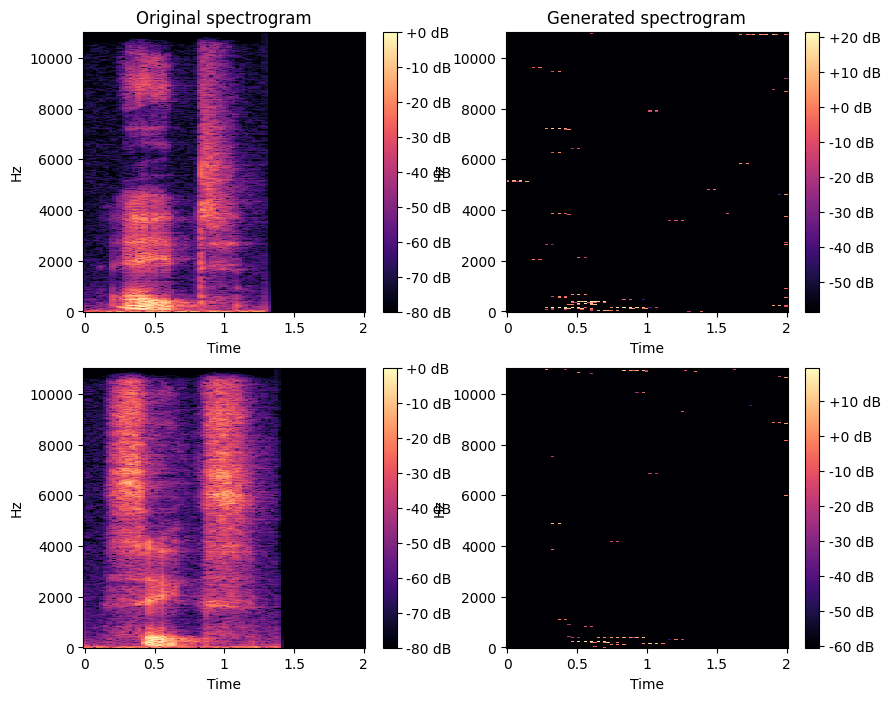

In [17]:
import matplotlib.pyplot as plt
noise = tf.random.normal(shape = generator_input_shape)
generated = gan_model.predict(noise)
n = 2
fig, ax = plt.subplots(n, 2, figsize = (10, 4 * n))
ax[0][0].set(title = "Original spectrogram")
ax[0][1].set(title = "Generated spectrogram")

for i in range(n):
    img_original = librosa.display.specshow(librosa.amplitude_to_db((X_test[i, :, :, 0])), x_axis='time', y_axis='linear', ax=ax[i][0])
    img_recon = librosa.display.specshow(librosa.amplitude_to_db(np.array(generated[i, :, :, 0])), x_axis='time', y_axis='linear', ax=ax[i][1])
    fig.colorbar(img_original, ax = ax[i][0], format = "%+2.f dB")
    fig.colorbar(img_recon, ax = ax[i][1], format = "%+2.f dB")

In [10]:
if load_model:
    gan_model.generator.load_weights(filepath = "C:/Users/damia/test_audio/gen.keras")
    gan_model.discriminator.load_weights(filepath = "C:/Users/damia/test_audio/disc.keras")

In [11]:
tf.random.set_seed(1234567)
noise = tf.random.normal(shape = generator_input_shape)
generated = gan_model.predict(noise)
sf.write("C:/Users/damia/test_audio/audio_generated.wav", librosa.util.normalize(librosa.griffinlim(np.array(generated[2, :, :, 0]))), samplerate=22050)

In [18]:
from IPython.display import Audio

noise = gan_model.predict(tf.random.normal(shape = generator_input_shape))
Audio(librosa.util.normalize(librosa.griffinlim(noise.numpy()[11, :, :, 0])), rate = 22050)

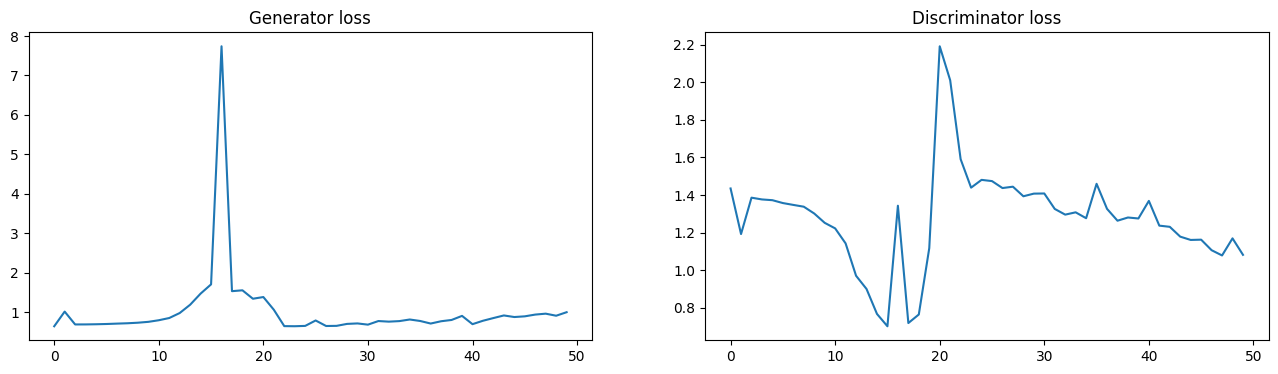

In [13]:
def plot_error(model_fit):
    fig, ax = plt.subplots(1, 2, figsize = (16, 4))
    ax[0].plot(model_fit.epoch, model_fit.history['gen_loss'], label = 'gen_loss')
    ax[0].set_title("Generator loss")
    ax[1].plot(model_fit.epoch, model_fit.history['disc_loss'], label = 'disc_loss')
    ax[1].set_title("Discriminator loss")
    plt.show()

plot_error(history)

In [14]:
#gan_model.generator.save("C:/Users/damia/test_audio/generator.keras")
#gan_model.discriminator.save("C:/Users/damia/test_audio/discriminator.keras")